# 1. Normalized Correlation

In [7]:
import depthai as dai

# Create pipeline
pipeline = dai.Pipeline()

# Define sources and output
camRgb = pipeline.create(dai.node.ColorCamera)
videoEnc = pipeline.create(dai.node.VideoEncoder)
xout = pipeline.create(dai.node.XLinkOut)

xout.setStreamName('h265')

# Properties
camRgb.setBoardSocket(dai.CameraBoardSocket.RGB)
camRgb.setResolution(dai.ColorCameraProperties.SensorResolution.THE_4_K)
videoEnc.setDefaultProfilePreset(30, dai.VideoEncoderProperties.Profile.H265_MAIN)

# Linking
camRgb.video.link(videoEnc.input)
videoEnc.bitstream.link(xout.input)

# Connect to device and start pipeline
with dai.Device(pipeline) as device:

    # Output queue will be used to get the encoded data from the output defined above
    q = device.getOutputQueue(name="h265", maxSize=30, blocking=True)

    # The .h265 file is a raw stream file (not playable yet)
    with open('video.h265', 'wb') as videoFile:
        print("Press Ctrl+C to stop encoding...")
        try:
            while True:
                h265Packet = q.get()  # Blocking call, will wait until a new data has arrived
                h265Packet.getData().tofile(videoFile)  # Appends the packet data to the opened file
        except KeyboardInterrupt:
            # Keyboard interrupt (Ctrl + C) detected
            pass

    print("To view the encoded data, convert the stream file (.h265) into a video file (.mp4) using a command below:")
    print("ffmpeg -framerate 30 -i video.h265 -c copy video.mp4")

Press Ctrl+C to stop encoding...
To view the encoded data, convert the stream file (.h265) into a video file (.mp4) using a command below:
ffmpeg -framerate 30 -i video.h265 -c copy video.mp4


In [9]:
!pip install ffmpeg-python


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import ffmpeg

try:
    ffmpeg.input('video.h265')\
    .filter('fps', fps=30, round='up')\
    .output('out4.mkv', vcodec='libx265')\
    .run(capture_stdout=True, capture_stderr=True)
    
except ffmpeg.Error as e:
    print('stdout:', e.stdout.decode('utf8'))
    print('stderr:', e.stderr.decode('utf8'))
    raise e

In [18]:
# create a folder to store extracted images
import os

folder = 'extracted_img_frames'
os.mkdir(folder)
# use opencv to do the job
import cv2
print(cv2.__version__)  # my version is 3.1.0
vidcap = cv2.VideoCapture('out4.mkv')
count = 0
while True:
    vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*250))
    success,image = vidcap.read()
    print ('Read a new frame: ', success)
    if not success:
        break
    cv2.imwrite(os.path.join(folder,"frame{:d}.jpg".format(count)), image)     # save frame as JPEG file
    count += 1
print("{} images are extacted in {}.".format(count,folder))

4.5.1
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  False
35 images are extacted in extracted_img_frames.


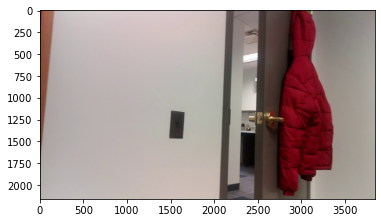

In [129]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("extracted_img_frames/frame1.jpg")
plt.imshow(img[:,:,::-1])

Cropped
(2000, 900, 3)


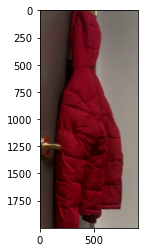

In [131]:
#object to be detected

print("Cropped")
crop_img = img[0:2000, 2600:3500]
print(crop_img.shape)
cv2.imwrite("cropped_img.jpg",crop_img)
plt.imshow(crop_img[:,:,::-1])

In [2]:
## Normalized Cross Correlation
import math

def norm_data(data):
    mean_data=np.mean(data)
    std_data=np.std(data, ddof=1)
    return (data-mean_data)/(std_data)


def ncc(im1, im2):
    #print(im1.shape, im2.shape)
    return (1.0/(im1.size-1)) * np.sum(norm_data(im1)*norm_data(im2))

def ssd(A,B):
    s = 0
    for i in range(3):
        s += sum(pow(A[:,:,i] - B[:,:,i],2))
    return s

In [21]:
import glob
import random 
import cv2

files = glob.glob("extracted_img_frames/*")
images = [cv2.imread(file) for file in files]
random_images = random.sample(images, 10)
crop_img = cv2.imread('cropped_img.jpg')[:,:,::-1]

In [4]:
crop_img.shape

(2000, 900, 3)

Image  1


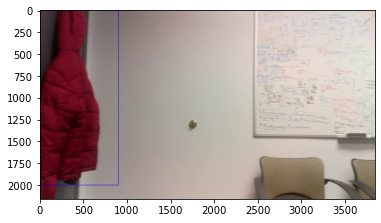

Image  2


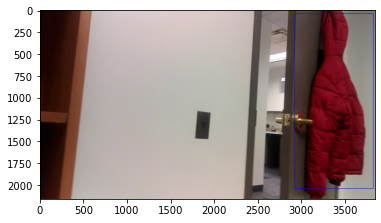

Image  3


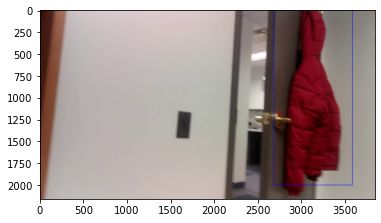

Image  4


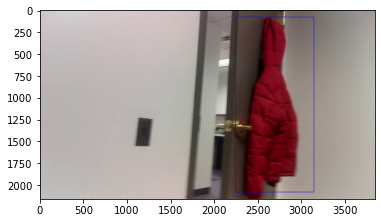

Image  5


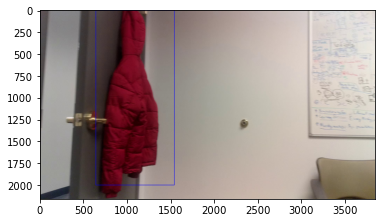

Image  6
Object not present


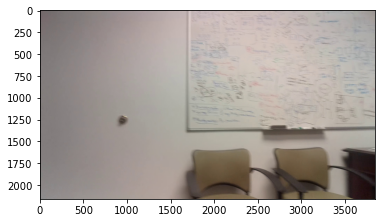

Image  7


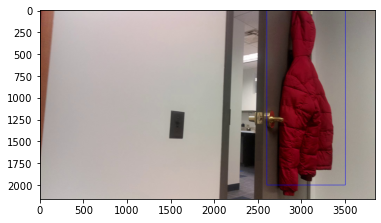

Image  8


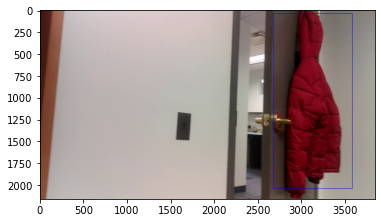

Image  9
Object not present


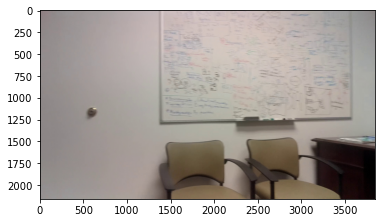

Image  10


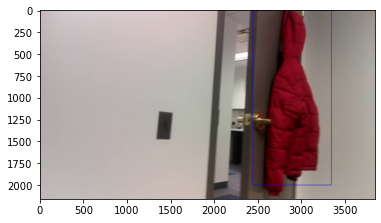

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def process(filename):
    image = mpimg.imread(filename)
    plt.imshow(image)
    plt.show()
                
count = 0
for im in random_images:
    #plt.imshow(im)
    #plt.show()
    d = {}
    print("Image ",count+1)
    for i in range(0,3200,40):
        #print(i,end=" ")
        for j in range(0,240,40):
            if crop_img.shape == im[j:j+2000,i:i+900].shape:
                d[str(j)+":"+str(j+2000),str(i)+":"+str(i+900)]=ncc(crop_img,im[j:j+2000,i:i+900])
            
    a=max(d.items(), key=lambda x: x[1])
    if a[1] > 0.45:
        y1,y2=map(int,a[0][0].split(':'))
        x1,x2=map(int,a[0][1].split(':'))

        color = (255, 0, 0)

        # Line thickness of 4 px
        thickness = 4

        # Using cv2.rectangle() method
        # Draw a rectangle with blue line borders of thickness of 2 px
        image = cv2.rectangle(im, (x1,y1), (x2,y2), color, thickness)

        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
        
    else:
        print("Object not present")
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.show()
        
            
    count += 1

# 2. Motion tracking

In [49]:
Iref=cv2.imread('extracted_img_frames/frame16.jpg',cv2.IMREAD_GRAYSCALE)
Inext=cv2.imread('extracted_img_frames/frame17.jpg',cv2.IMREAD_GRAYSCALE)
Iref=np.array(Iref).astype(np.float32)
Inext=np.array(Inext).astype(np.float32)
kernel_x = np.array([[-1., 1.], [-1., 1.]])*.25
kernel_y = np.array([[-1., -1.], [1., 1.]])*.25
kernel_t = np.array([[1., 1.], [1., 1.]])*.25
Iref = Iref / 255. # normalize pixels
Inext = Inext / 255. # normalize pixels
Ix=cv2.filter2D(Iref,-1,kernel=kernel_x)
Iy=cv2.filter2D(Iref,-1,kernel=kernel_y)
It=cv2.filter2D(Iref,-1,kernel=kernel_t)+cv2.filter2D(Inext,-1,kernel=kernel_x)
Ix,Iy,It=np.array(Ix),np.array(Iy),np.array(It)

u=np.divide(It,np.sqrt(np.square(Ix)+np.square(Iy)))
u

<ipython-input-49-b6cf0e45d0a7>:15: RuntimeWarning: divide by zero encountered in divide
  u=np.divide(It,np.sqrt(np.square(Ix)+np.square(Iy)))


array([[ 28.39805 ,  30.634111,  13.489827, ..., 189.03372 ,  94.50933 ,
         63.40386 ],
       [ 28.398045,  30.634125,  13.489827, ..., 189.03323 ,  94.50919 ,
         63.40391 ],
       [ 18.950462,  20.930363,  21.071783, ..., 112.049324, 569.221   ,
        283.19516 ],
       ...,
       [ 27.252323,  27.408495,  42.07993 , ...,  79.75    ,  39.522392,
         47.66667 ],
       [ 57.39534 ,  57.07912 ,  26.383516, ...,  31.200003,  39.31514 ,
        144.50002 ],
       [ 34.910725,  33.425163,  22.515417, ...,  35.65274 ,  88.22756 ,
         92.338524]], dtype=float32)

## Image registration of consecutive frames

Registering consecutive frames - 


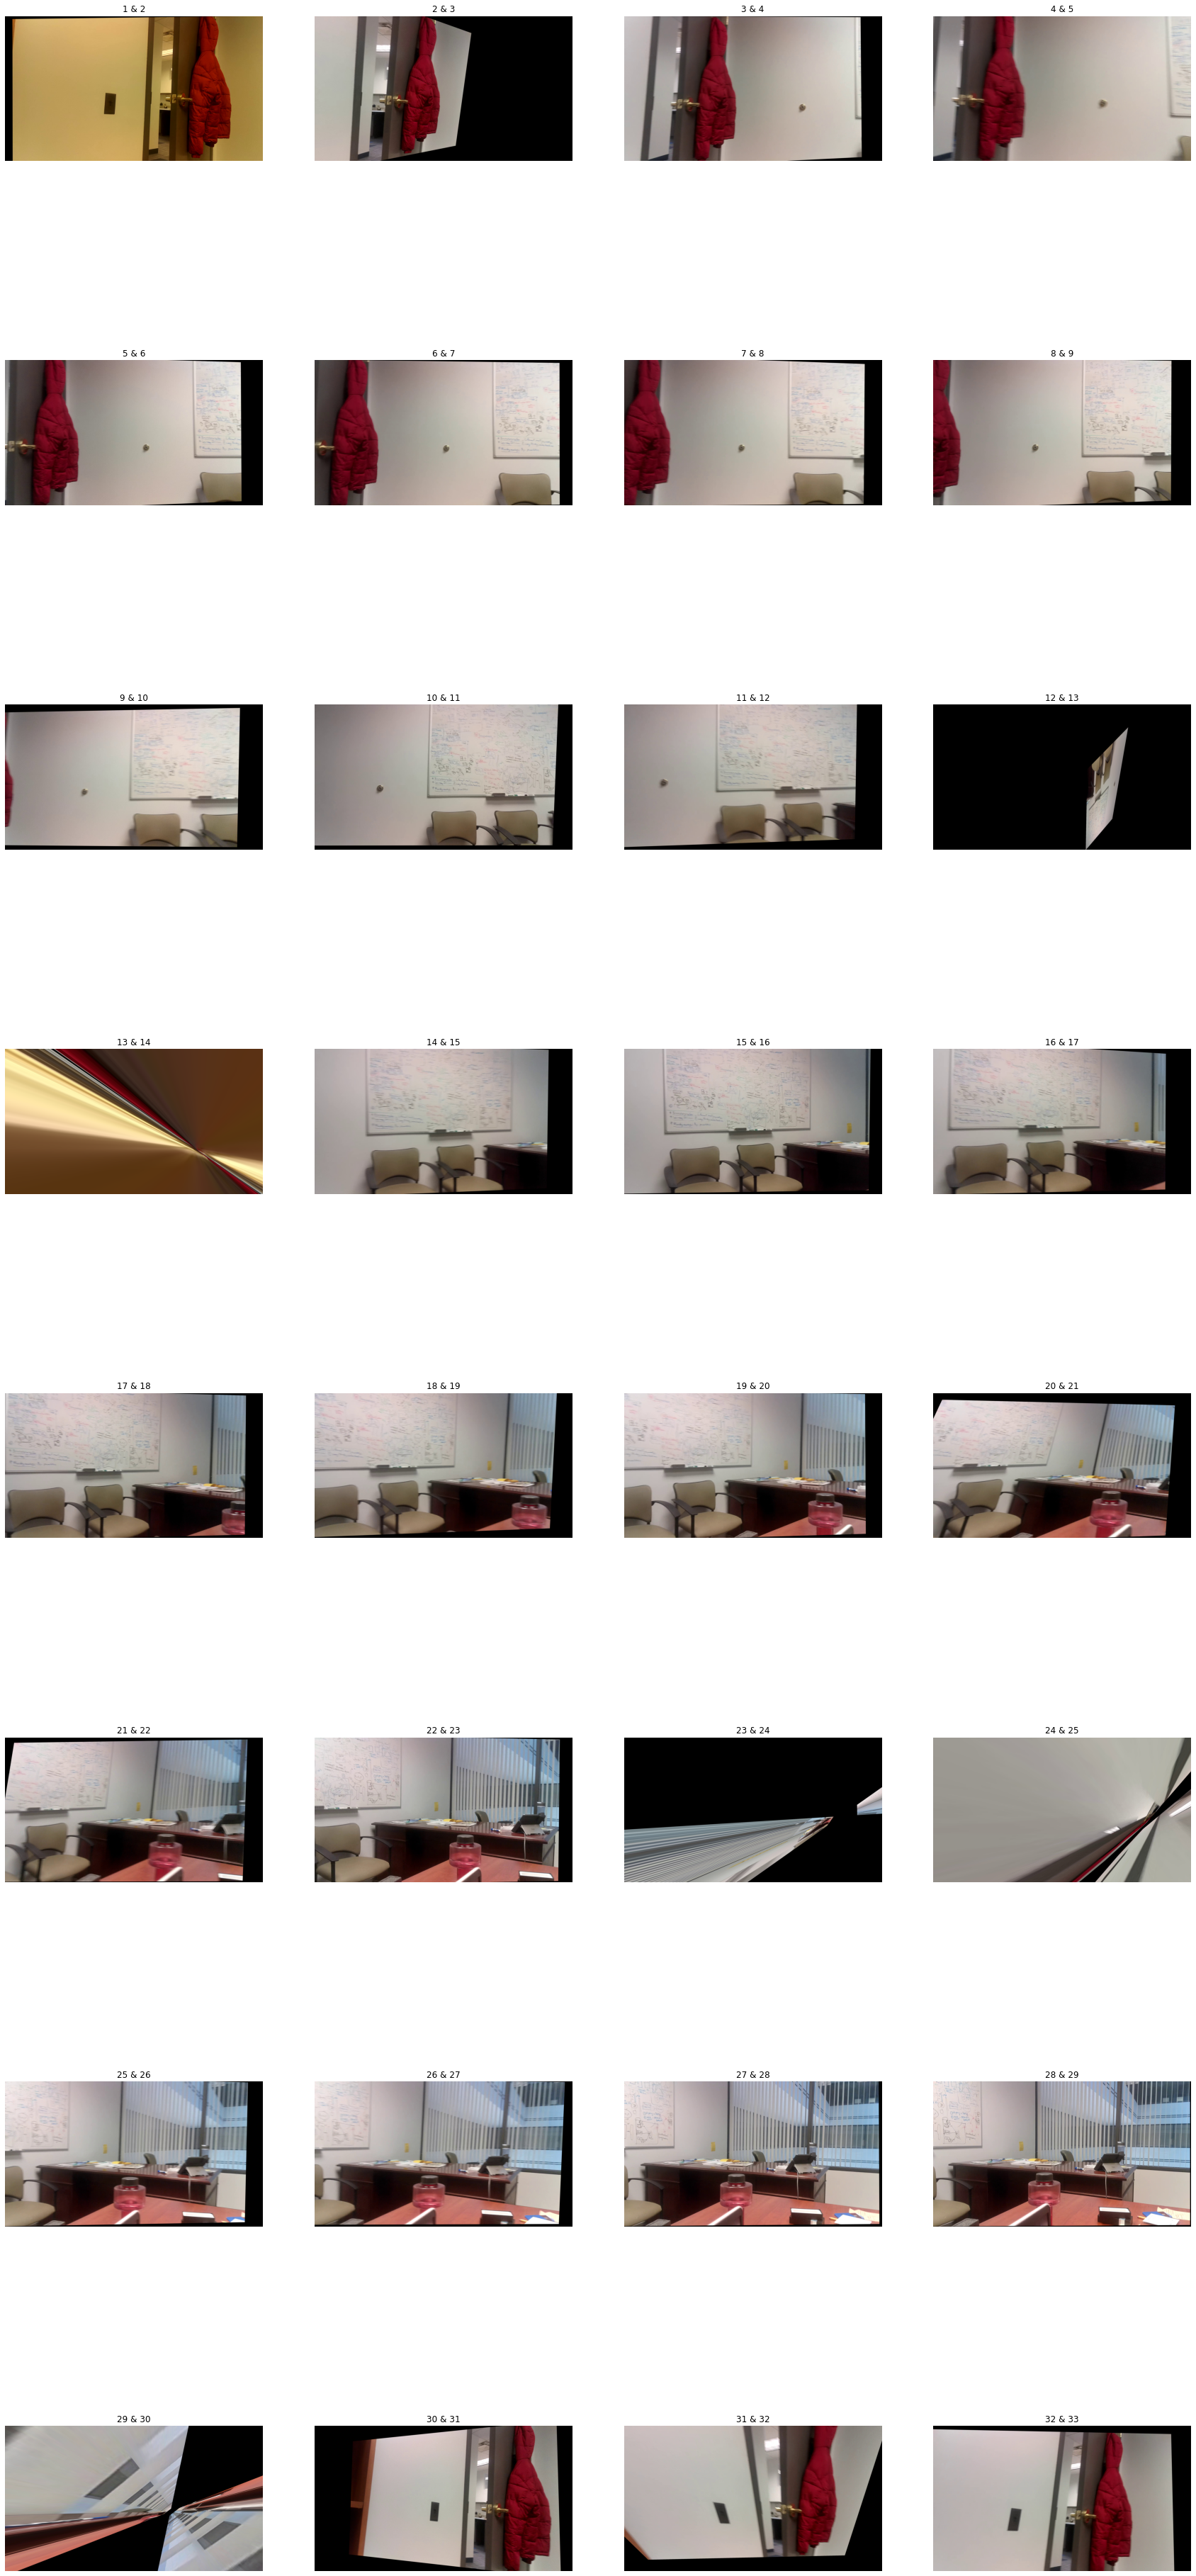

In [64]:
#Image registration

import cv2
import numpy as np
 
files = glob.glob("extracted_img_frames/*")
images = [cv2.imread(file) for file in files][:33]

# create figure
fig = plt.figure(figsize=(30,70))
  
# setting values to rows and column variables
rows = 8
columns = 4

print("Registering consecutive frames - ")

for im in range(len(images)-1): 
    
    #print("Registering the images, "+str(im)+" & "+str(im+1))

    im1 = images[im]  # Image to be aligned.
    im2 = images[im+1]   # Reference image.

    # Convert to grayscale.
    img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    height, width = img2.shape

    # ORB detector
    orb= cv2.ORB_create(5000)

    # keypoints and descript
    kp1, d1 = orb.detectAndCompute(img1, None)
    kp2, d2 = orb.detectAndCompute(img2, None)


    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)


    matches = matcher.match(d1, d2)
    matches.sort(key = lambda x: x.distance)

    # top 90 % matches
    matches = matches[:int(len(matches)*0.9)]
    n_matches = len(matches)

    # Define empty matrices of shape no_of_matches * 2.
    z1 = np.zeros((n_matches, 2))
    z2 = np.zeros((n_matches, 2))

    for i in range(len(matches)):
        z1[i, :] = kp1[matches[i].queryIdx].pt
        z2[i, :] = kp2[matches[i].trainIdx].pt

    # Find the homography matrix.
    H, mask = cv2.findHomography(z1, z2, cv2.RANSAC)

    # Use this matrix to transform the
    # colored image wrt the reference image.
    realigned_img = cv2.warpPerspective(im1,
                        H, (width, height))

    # Save the output.
    #cv2.imwrite('realign-output.jpg', realigned_img)

    #res = cv2.imread('realign-output.jpg')[:,:,::-1]
    
    fig.add_subplot(rows, columns, im+1)
    plt.title(str(im+1)+" & "+str(im+2))
    plt.axis('off')
    plt.imshow(realigned_img[:,:,::-1])

# 3. Optical flow

### a. Every previous frame as reference

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture('out4.mkv')

# Read the frame
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
prev_frame = frame

jump = 16
n = 0
c = 0

while True:
    
    # Read the frame
    ret, frame = cap.read()
    
    if ret:
        print(c)
        # Sets image saturation to maximum
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate Optical Flow
        op_flow = cv2.calcOpticalFlowFarneback(prev_frame, frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        h, w = frame.shape[:2]
        y, x = np.mgrid[jump/2:h:jump, jump/2:w:jump].reshape(2,-1).astype(int)
        fx, fy = op_flow[y,x].T

        lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
        lines = np.int32(lines + 0.5)

        
        # Convert HSV image into BGR for demo
        bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        cv2.polylines(bgr, lines, 0, (0, 255, 0),1)

        for (x1, y1), (_x2, _y2) in lines:
            cv2.circle(bgr, (x1, y1), 1, (0, 0, 255), 1)

        # Update the previous frame
        prev_frame = frame
        cv2.imshow("frame", bgr)
        
    c += 1
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break

### b. Every 11th frame as reference

In [1]:
import numpy as np
import cv2

cap = cv2.VideoCapture('out4.mkv')

# Read the frame
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
prev_frame = frame

jump = 16
n = 10
c = 0

while True:
    
    # Read the frame
    ret, frame = cap.read()
    
    if ret and c%n==0:
        print(c)
        # Sets image saturation to maximum
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate Optical Flow
        op_flow = cv2.calcOpticalFlowFarneback(prev_frame, frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        h, w = frame.shape[:2]
        y, x = np.mgrid[jump/2:h:jump, jump/2:w:jump].reshape(2,-1).astype(int)
        fx, fy = op_flow[y,x].T

        lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
        lines = np.int32(lines + 0.5)

        
        # Convert HSV image into BGR for demo
        bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        cv2.polylines(bgr, lines, 0, (0, 255, 0),1)

        for (x1, y1), (_x2, _y2) in lines:
            cv2.circle(bgr, (x1, y1), 1, (0, 0, 255), 1)

        # Update the previous frame
        prev_frame = frame
        cv2.imshow("frame", bgr)
        
    c += 1
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250


### (iii). Every 31st frame as reference

In [1]:
import numpy as np
import cv2

cap = cv2.VideoCapture('out4.mkv')

# Read the frame
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
prev_frame = frame

jump = 16
n = 30
c = 0

while True:
    
    # Read the frame
    ret, frame = cap.read()
    
    if ret and c%n==0:
        print(c)
        # Sets image saturation to maximum
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate Optical Flow
        op_flow = cv2.calcOpticalFlowFarneback(prev_frame, frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        h, w = frame.shape[:2]
        y, x = np.mgrid[jump/2:h:jump, jump/2:w:jump].reshape(2,-1).astype(int)
        fx, fy = op_flow[y,x].T

        lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
        lines = np.int32(lines + 0.5)

        
        # Convert HSV image into BGR for demo
        bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        cv2.polylines(bgr, lines, 0, (0, 255, 0),1)

        for (x1, y1), (_x2, _y2) in lines:
            cv2.circle(bgr, (x1, y1), 1, (0, 0, 255), 1)

        # Update the previous frame
        prev_frame = frame
        cv2.imshow("frame", bgr)
        
    c += 1
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break

0
30
60
90
120
150
180
210
240


# 4. SIFT feature based object detection

Training Images -


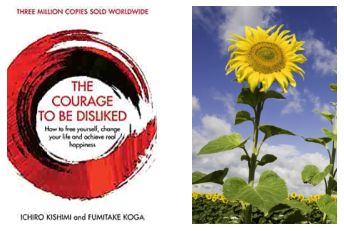

In [113]:
import cv2
import matplotlib.pyplot as plt

print("Training Images -")
path_train = 'obj_detection_train'
list_imgs_train = os.listdir(path_train)

images_train = []
c = 1
for im in list_imgs_train:
    img = cv2.imread(path_train+'/'+im)
    images_train.append(img)
    
    plt.subplot(1,2,c)
    plt.axis("off")
    c+=1
    plt.imshow(img[:,:,::-1])

Testing Images - 


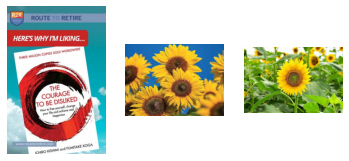

In [114]:
import cv2
import matplotlib.pyplot as plt

print("Testing Images - ")
path_test = 'obj_detection_test'
list_imgs_test = os.listdir(path_test)

images_test = []
c = 1
for im in list_imgs_test:
    img = cv2.imread(path_test+'/'+im)
    images_test.append(img)
    
    plt.subplot(1,3,c)
    plt.axis("off")
    c+=1
    plt.imshow(img[:,:,::-1])

total classes 2
classes:  ['book', 'flower']


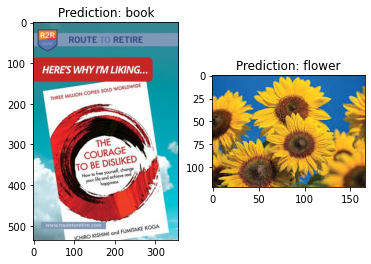

In [112]:
# classifier

import os

path = 'obj_detection_train'
images = []
classes = []
list_imgs = os.listdir(path)
print("total classes",len(list_imgs))

for im in list_imgs:
    img = cv2.imread(path+'/'+im,0)
    images.append(img)
    classes.append(im.split('_')[0])
    
print("classes: ",classes)

sift = cv2.xfeatures2d.SIFT_create()

def find_features(imgs):
    desp_imgs = []
    for im in imgs:
        kp,desp = sift.detectAndCompute(im, None)
        desp_imgs.append(desp)
        
    return desp_imgs

desp_imgs_train = find_features(images)

def get_matches(img, desp_list):
    kp2, desp2 = sift.detectAndCompute(img, None)
    matcher = cv2.BFMatcher()
    
    match_list = []
    
    res = -1
    
    for desp in desp_list:
        raw_matches = matcher.knnMatch(desp, desp2, k=2)
        good_points = []
        good_matches=[]
        for m1, m2 in raw_matches:
            if m1.distance < 0.85 * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        match_list.append(len(good_matches))
    
    #print(match_list)
    if len(match_list) != 0:
        if max(match_list) > 15:
            res = match_list.index(max(match_list))
            
    return res

        
#Testing the classifier
path_test = 'obj_detection_test'
list_imgs_test = os.listdir(path_test)

images_test = []
c = 1
for im in list_imgs_test:
    img = cv2.imread(path_test+'/'+im)
    images_test.append(img)

for img in images_test:
    index = get_matches(img, desp_imgs_train)
    
    if index != -1 and 0<c<3:
        s = "Prediction: " + classes[index]
        plt.subplot(1,2,c)
        plt.title(s)
        plt.imshow(img[:,:,::-1])
        #plt.show()
        c+=1

# 5. Multiple face detection 

In [10]:

import numpy as np
import cv2

# multiple cascades: https://github.com/Itseez/opencv/tree/master/data/haarcascades

faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

predicted = []

img_counter = 0

while True:
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors=5,minSize=(20, 20))
    
    #print(len(faces))
    
    c = 0

    for (x,y,w,h) in faces:
        c += 1
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        
        if k%256 == 32 and c==1:
            # SPACE pressed
            img_name = "multiple_face_detection/opencv_frame_{}.png".format(img_counter)
            cv2.imwrite(img_name, img)
            print("{} written!".format(img_name))
            predicted.append(len(faces))
            print(len(faces))
            img_counter += 1
        

    cv2.imshow('video',img) 

    k = cv2.waitKey(30) & 0xff
    if k == 27: # press 'ESC' to quit
        break
        

cap.release()
cv2.destroyAllWindows()

multiple_face_detection/opencv_frame_0.png written!
4
multiple_face_detection/opencv_frame_1.png written!
5
multiple_face_detection/opencv_frame_2.png written!
2
multiple_face_detection/opencv_frame_3.png written!
4
multiple_face_detection/opencv_frame_4.png written!
6
multiple_face_detection/opencv_frame_5.png written!
2
multiple_face_detection/opencv_frame_6.png written!
3
multiple_face_detection/opencv_frame_7.png written!
2
multiple_face_detection/opencv_frame_8.png written!
1
multiple_face_detection/opencv_frame_9.png written!
2
multiple_face_detection/opencv_frame_10.png written!
2
multiple_face_detection/opencv_frame_11.png written!
5
multiple_face_detection/opencv_frame_12.png written!
3
multiple_face_detection/opencv_frame_13.png written!
2
multiple_face_detection/opencv_frame_14.png written!
1
multiple_face_detection/opencv_frame_15.png written!
2
multiple_face_detection/opencv_frame_16.png written!
4
multiple_face_detection/opencv_frame_17.png written!
4
multiple_face_detect

In [13]:
true_face_count = [4,5,3,4,6,5,3,4,1,2,3,4,3,2,1,3,5,4,3,5,2,4,1,3,4,4,4,7,3]
print(true_face_count)
print(predicted)

[4, 5, 3, 4, 6, 5, 3, 4, 1, 2, 3, 4, 3, 2, 1, 3, 5, 4, 3, 5, 2, 4, 1, 3, 4, 4, 4, 7, 3]
[4, 5, 2, 4, 6, 2, 3, 2, 1, 2, 2, 5, 3, 2, 1, 2, 4, 4, 3, 5, 1, 3, 1, 3, 5, 3, 4, 6, 3]


Accuracy: 0.5862068965517241
Precision: 0.6386699507389163
Recall: 0.5862068965517241


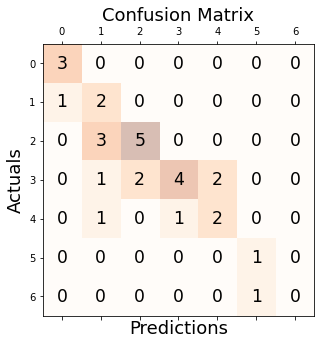

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt

print("Accuracy:",accuracy_score(true_face_count,predicted))
print("Precision:",precision_score(true_face_count,predicted,average='weighted'))
print("Recall:",recall_score(true_face_count,predicted,average='weighted'))

conf_matrix = confusion_matrix(true_face_count, predicted)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1]:

import numpy as np
import cv2

# multiple cascades: https://github.com/Itseez/opencv/tree/master/data/haarcascades

faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

predicted = []

img_counter = 0
predicted = []

while True:
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors=5,minSize=(20, 20))
    
    k = cv2.waitKey(30) & 0xff
    
    #print(len(faces))
    
    c = 0

    for (x,y,w,h) in faces:
        c += 1
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        
        if k%256 == 32 and c==1:
            # SPACE pressed
            img_name = "iou_img.png"
            cv2.imwrite(img_name, img)
            print("{} written!".format(img_name))
            predicted.append(len(faces))
            print(len(faces))
            img_counter += 1
            
        predicted = [x,y,w,h]
        

    cv2.imshow('video',img) 

    
    if k == 27: # press 'ESC' to quit
        break
        

cap.release()
cv2.destroyAllWindows()

print(predicted)

iou_img.png written!
1
[258, 112, 237, 237]


predicted bounding box [258, 112, 237, 237]


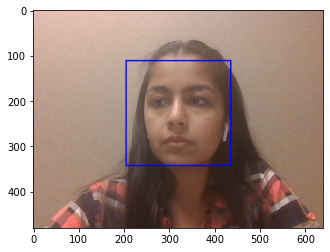

In [5]:
import matplotlib.pyplot as plt

img = cv2.imread('iou_img.png')
plt.imshow(img[:,:,::-1])

print("predicted bounding box",predicted)

# 6

In [10]:
# capture images

#!/usr/bin/env python3

import time
from pathlib import Path

import cv2
import depthai as dai

# Start defining a pipeline
pipeline = dai.Pipeline()

# Define a source - color camera
camRgb = pipeline.createColorCamera()
camRgb.setResolution(dai.ColorCameraProperties.SensorResolution.THE_4_K)

# Create RGB output
xoutRgb = pipeline.createXLinkOut()
xoutRgb.setStreamName("rgb")
camRgb.video.link(xoutRgb.input)

# Create encoder to produce JPEG images
videoEnc = pipeline.createVideoEncoder()
videoEnc.setDefaultProfilePreset(camRgb.getVideoSize(), camRgb.getFps(), dai.VideoEncoderProperties.Profile.MJPEG)
camRgb.video.link(videoEnc.input)

# Create JPEG output
xoutJpeg = pipeline.createXLinkOut()
xoutJpeg.setStreamName("jpeg")
videoEnc.bitstream.link(xoutJpeg.input)


# Connect and start the pipeline
with dai.Device(pipeline) as device:

    # Output queue will be used to get the rgb frames from the output defined above
    qRgb = device.getOutputQueue(name="rgb", maxSize=30, blocking=False)
    qJpeg = device.getOutputQueue(name="jpeg", maxSize=30, blocking=True)

    # Make sure the destination path is present before starting to store the examples
    Path('06_data').mkdir(parents=True, exist_ok=True)

    while True:
        inRgb = qRgb.tryGet()  # Non-blocking call, will return a new data that has arrived or None otherwise

        if inRgb is not None:
            cv2.imshow("rgb", inRgb.getCvFrame())

        for encFrame in qJpeg.tryGetAll():
            with open(f"06_data/{int(time.time() * 10000)}.jpeg", "wb") as f:
                f.write(bytearray(encFrame.getData()))

        if cv2.waitKey(1) == ord('q'):
            break

<ipython-input-10-14916b4b032d>:25: DeprecationWarning: Input size no longer needed, automatically determined from first frame
  videoEnc.setDefaultProfilePreset(camRgb.getVideoSize(), camRgb.getFps(), dai.VideoEncoderProperties.Profile.MJPEG)


In [8]:
# get world (x,y) points for first image (04_data)

import math
import cv2

# function to display the coordinates of
# of the points clicked on the image
def click_event(event, x, y, flags, params):
 
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
 
        # displaying the coordinates
        # on the Shell
        x_point.append(x)
        y_point.append(y)
        print(x, ',', y)
 
        # displaying the coordinates
        # on the image window
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, str(x) + ',' +
                    str(y), (x,y), font,
                    1, (255, 0, 0), 2)
        cv2.imshow('image', img)
        
        
#focal length values obtained after camera calibration in Part A Q1
fx = 2984.2
fy = 2980.4

#distance between object and camera (in pixels)
z = 9728

# reading the image
img = cv2.imread('disparity1.jpeg')

# displaying the image
cv2.imshow('image', img)

#initializng image points list
x_point = []
y_point = []
print("The (x,y) image points (Image coordinates): ")
cv2.setMouseCallback('image', click_event)

cv2.waitKey(0)
cv2.destroyAllWindows()

#world coordinates of the points
x1 = z*(x_point[0])/fx
y1 = z*(y_point[0])/fy

print("World coordinates of first image:",(x1,y1))

The (x,y) image points (Image coordinates): 
1721 , 777
World coordinates of first image: (5610.176261644662, 2536.1213259965107)


In [6]:
# get world (x,y) points for second image (06_data)

import math
import cv2

# function to display the coordinates of
# of the points clicked on the image
def click_event(event, x, y, flags, params):
 
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
 
        # displaying the coordinates
        # on the Shell
        x_point.append(x)
        y_point.append(y)
        print(x, ',', y)
 
        # displaying the coordinates
        # on the image window
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, str(x) + ',' +
                    str(y), (x,y), font,
                    1, (255, 0, 0), 2)
        cv2.imshow('image', img)
        
        
#focal length values obtained after camera calibration in Part A Q1
fx = 2984.2
fy = 2980.4

#distance between object and camera (in pixels)
z = 11058

# reading the image
img = cv2.imread('disparity2.jpeg')

# displaying the image
cv2.imshow('image', img)

#initializng image points list
x_point = []
y_point = []
print("The (x,y) image points (Image coordinates): ")
cv2.setMouseCallback('image', click_event)

cv2.waitKey(0)
cv2.destroyAllWindows()

#world coordinates of the points
x2 = z*(x_point[0])/fx
y2 = z*(y_point[0])/fy

print("World coordinates of second image:",(x2,y2))

The (x,y) image points (Image coordinates): 
1493 , 861
World coordinates of second image: (5532.334964144495, 3194.516843376728)


In [11]:
# distance calculation
f = fx  #focal lentgh of camera
b =  352 #baseline - distance between 2 camera
d = f*b/(x1-x2)

print(d)

13494.615759683864


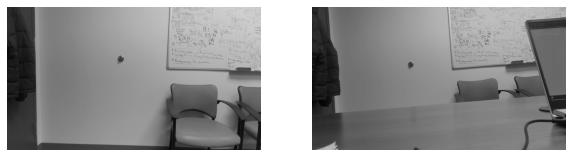

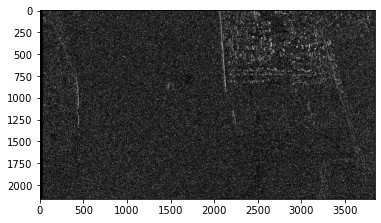

In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def disparity(im1,im2):
    stereo = cv2.StereoBM_create(numDisparities=32, blockSize=5)
    disparity = stereo.compute(im1,im2)
    
    min=disparity.min()
    max=disparity.max()
    disparity = np.uint8(255*(disparity-min)/(max-min))
   
    return disparity

im1 = cv2.imread("disparity1.jpeg",0)
im2 = cv2.imread("disparity2.jpeg",0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(im1, 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(im2, 'gray')
plt.axis('off')
plt.show()

res = disparity(im1,im2)
plt.imshow(res,'gray')